In [4]:
# Install necessary libraries
!pip install pandas numpy scikit-learn imbalanced-learn nltk textblob seaborn matplotlib wordcloud


In [6]:
# Import necessary libraries
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from scipy.sparse import hstack
import numpy as np


In [8]:

# Load the dataset
data = pd.read_csv('trains.csv')
print(data.head())


                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  


In [10]:

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [12]:


# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


In [14]:

# Function to preprocess text
def preprocess_text(text):
    # Lowercasing
    text = text.lower()
    # Removing punctuation and special characters
    text = re.sub(r'[^a-z\s]', '', text)
    # Removing stop words
    words = text.split()
    words = [word for word in words if word not in stop_words]
    # Lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)


In [16]:

# Apply preprocessing to the 'comment_text' column
data['cleaned_text'] = data['comment_text'].apply(preprocess_text)
print(data['cleaned_text'].head())


0    explanation edits made username hardcore metal...
1    daww match background colour im seemingly stuc...
2    hey man im really trying edit war guy constant...
3    cant make real suggestion improvement wondered...
4                  sir hero chance remember page thats
Name: cleaned_text, dtype: object


In [18]:

# Function to tokenize text
def tokenize_text(text):
    return word_tokenize(text)

In [20]:

# Apply tokenization
data['tokenized_text'] = data['cleaned_text'].apply(tokenize_text)
print(data['tokenized_text'].head())

0    [explanation, edits, made, username, hardcore,...
1    [daww, match, background, colour, im, seemingl...
2    [hey, man, im, really, trying, edit, war, guy,...
3    [cant, make, real, suggestion, improvement, wo...
4           [sir, hero, chance, remember, page, thats]
Name: tokenized_text, dtype: object


In [22]:

# Initialize TfidfVectorizer and transform the 'cleaned_text' column
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(data['cleaned_text'])
print(X_tfidf.shape)

(159571, 212529)


In [24]:
# Initialize SMOTE and apply to the dataset
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_tfidf, data['toxic'])
print(X_resampled.shape, y_resampled.shape)

(288540, 212529) (288540,)


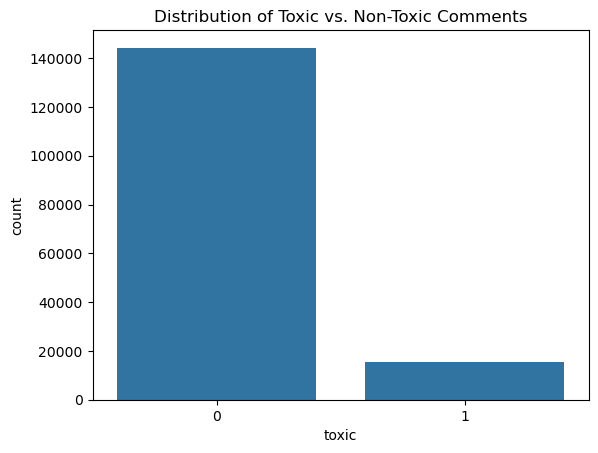

In [12]:
# Plot the distribution of toxic vs. non-toxic comments
sns.countplot(x='toxic', data=data)
plt.title('Distribution of Toxic vs. Non-Toxic Comments')
plt.show()

In [25]:
# Generate WordClouds for toxic and non-toxic comments
toxic_comments = data[data['toxic'] == 1]['cleaned_text']
non_toxic_comments = data[data['toxic'] == 0]['cleaned_text']


In [28]:

toxic_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(toxic_comments))
non_toxic_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(non_toxic_comments))


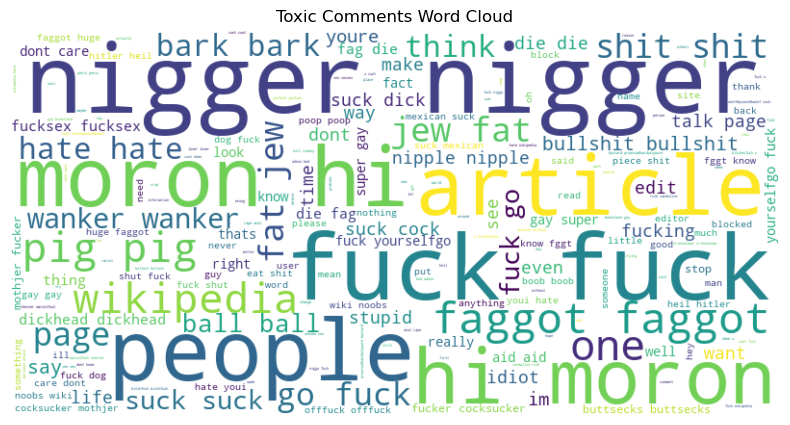

In [30]:

# Plotting the toxic comments WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(toxic_wordcloud, interpolation='bilinear')
plt.title('Toxic Comments Word Cloud')
plt.axis('off')
plt.show()


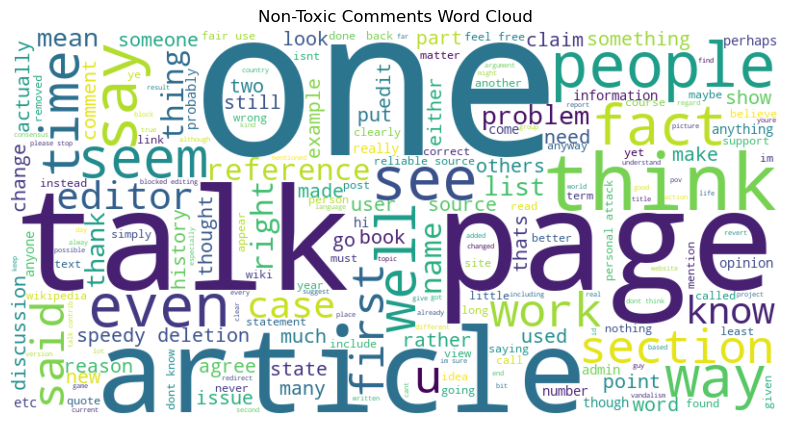

In [32]:

# Plotting the non-toxic comments WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(non_toxic_wordcloud, interpolation='bilinear')
plt.title('Non-Toxic Comments Word Cloud')
plt.axis('off')
plt.show()

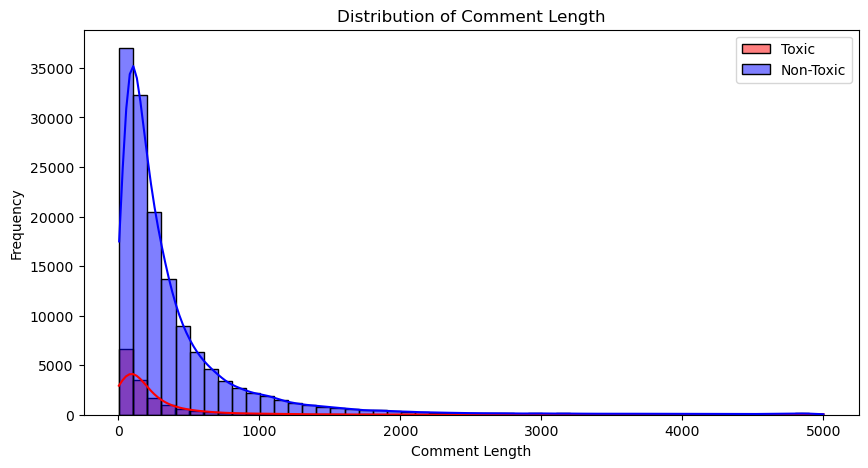

In [34]:


# Calculate comment lengths and plot the distribution
data['comment_length'] = data['comment_text'].apply(len)
plt.figure(figsize=(10, 5))
sns.histplot(data[data['toxic'] == 1]['comment_length'], bins=50, color='red', kde=True, label='Toxic')
sns.histplot(data[data['toxic'] == 0]['comment_length'], bins=50, color='blue', kde=True, label='Non-Toxic')
plt.legend()
plt.title('Distribution of Comment Length')
plt.xlabel('Comment Length')
plt.ylabel('Frequency')
plt.show()


In [36]:

# Function to plot n-grams (Bi-grams, Tri-grams)
def plot_ngrams(corpus, ngram_range=(1, 1), top_n=20):
    vec = CountVectorizer(ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    common_words = words_freq[:top_n]
    df_common_words = pd.DataFrame(common_words, columns=['word', 'count'])
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x='count', y='word', data=df_common_words)
    plt.title(f'Top {top_n} {ngram_range[0]}-grams')
    plt.xlabel('Count')
    plt.ylabel('N-gram')
    plt.show()

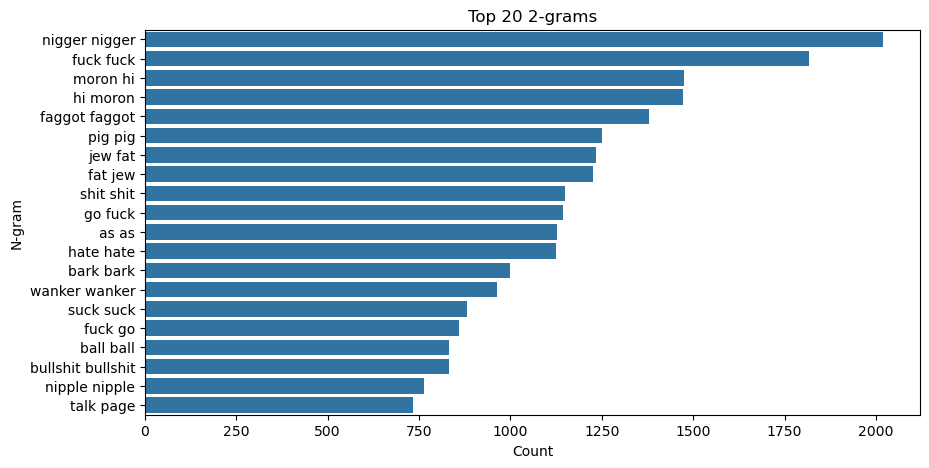

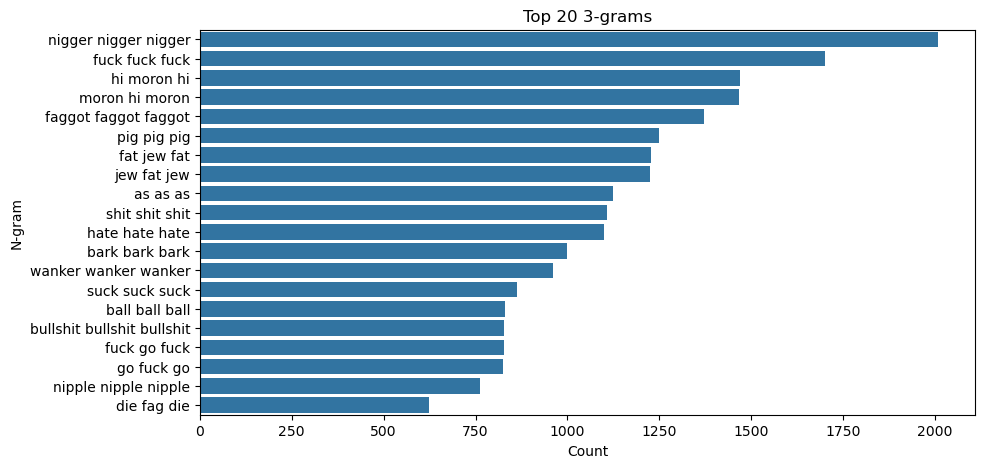

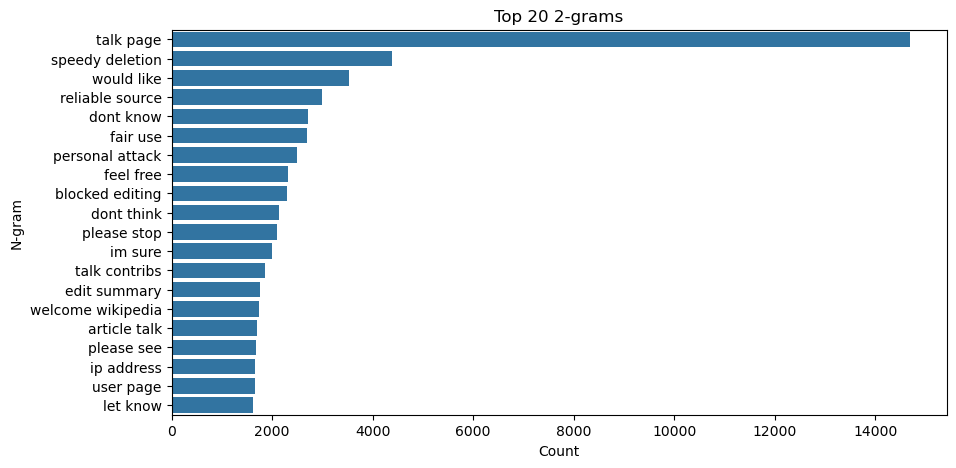

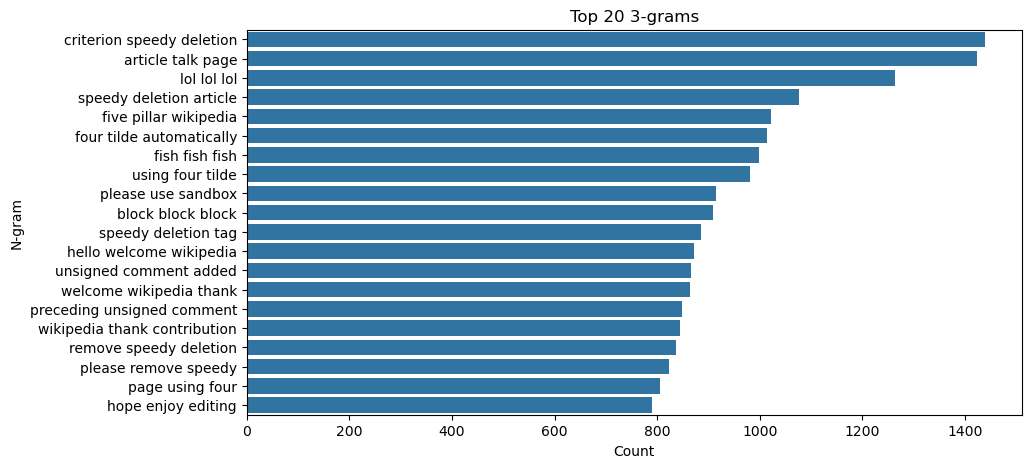

In [38]:


# Plot bi-grams and tri-grams for toxic and non-toxic comments
plot_ngrams(data[data['toxic'] == 1]['cleaned_text'], ngram_range=(2, 2), top_n=20)
plot_ngrams(data[data['toxic'] == 1]['cleaned_text'], ngram_range=(3, 3), top_n=20)
plot_ngrams(data[data['toxic'] == 0]['cleaned_text'], ngram_range=(2, 2), top_n=20)
plot_ngrams(data[data['toxic'] == 0]['cleaned_text'], ngram_range=(3, 3), top_n=20)

In [40]:


# Calculate sentiment polarity for each comment
data['sentiment'] = data['comment_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

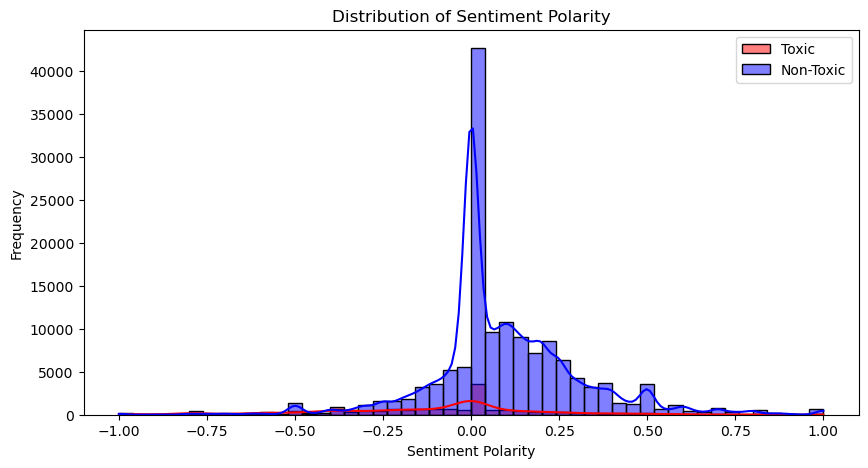

In [42]:

# Plot the distribution of sentiment polarity
plt.figure(figsize=(10, 5))
sns.histplot(data[data['toxic'] == 1]['sentiment'], bins=50, color='red', kde=True, label='Toxic')
sns.histplot(data[data['toxic'] == 0]['sentiment'], bins=50, color='blue', kde=True, label='Non-Toxic')
plt.legend()
plt.title('Distribution of Sentiment Polarity')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()


In [44]:

# Feature extraction: Combine TF-IDF, N-grams, and Sentiment
count_vectorizer_bigram = CountVectorizer(ngram_range=(2, 2))  # Bi-grams
X_bigram = count_vectorizer_bigram.fit_transform(data['cleaned_text'])


In [46]:

count_vectorizer_trigram = CountVectorizer(ngram_range=(3, 3))  # Tri-grams
X_trigram = count_vectorizer_trigram.fit_transform(data['cleaned_text'])


In [48]:

# Combine features
X_combined = hstack([X_tfidf, X_bigram, X_trigram, np.array(data['sentiment']).reshape(-1, 1)])


In [50]:

# Apply SMOTE on the combined features
X_resampled, y_resampled = smote.fit_resample(X_combined, data['toxic'])
print(X_resampled.shape, y_resampled.shape)


(288540, 6968187) (288540,)


In [52]:

# Split the dataset into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [54]:

# Initialize and train Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)


C:\Users\rahul\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [56]:

# Make predictions on the validation set
y_pred = model.predict(X_valid)


In [58]:

# Evaluate the model
print("Classification Report:")
print(classification_report(y_valid, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     28866
           1       0.94      1.00      0.97     28842

    accuracy                           0.97     57708
   macro avg       0.97      0.97      0.97     57708
weighted avg       0.97      0.97      0.97     57708



In [60]:

print("\nConfusion Matrix:")
print(confusion_matrix(y_valid, y_pred))



Confusion Matrix:
[[27162  1704]
 [   24 28818]]


In [62]:


# Classify new comments with additional features
def classify_comments_with_features(comments):
    # Preprocess the new comments
    processed_comments = [preprocess_text(comment) for comment in comments]
    
    # Transform the comments using the trained TF-IDF vectorizer
    X_new_tfidf = tfidf_vectorizer.transform(processed_comments)
    
    # Calculate the sentiment for each new comment
    sentiment_new = [TextBlob(comment).sentiment.polarity for comment in comments]
    X_new_sentiment = np.array(sentiment_new).reshape(-1, 1)
    
    # Transform new comments using the CountVectorizer for bi-grams and tri-grams
    X_new_bigram = count_vectorizer_bigram.transform(processed_comments)
    X_new_trigram = count_vectorizer_trigram.transform(processed_comments)
    
    # Combine the features (TF-IDF, Bi-grams, Tri-grams, Sentiment)
    X_new_combined = hstack([X_new_tfidf, X_new_bigram, X_new_trigram, X_new_sentiment])
    
    # Predict toxicity using the trained model
    predictions = model.predict(X_new_combined)
    
    # Return the predictions
    return predictions


In [78]:

# Example new comments for classification
new_comments = [  "you are a nice guy",
                "i want you",
                "our project is good",
                "ravi is a bad guy",
                "You're so dumb, why would you even think that?",
                "You're worthless and will never succeed.",
                "Shut up, you're just looking for attention.",
                "I don't agree with you, but I see where you're coming from.",

            
]


In [80]:


# Classify the new comments
predictions = classify_comments_with_features(new_comments)


In [82]:

# Display the results
for comment, prediction in zip(new_comments, predictions):
    print(f"Comment: '{comment}'\nPrediction: {'Toxic' if prediction == 1 else 'Non-Toxic'   }\n")


Comment: 'you are a nice guy'
Prediction: Non-Toxic

Comment: 'i want you'
Prediction: Toxic

Comment: 'our project is good'
Prediction: Non-Toxic

Comment: 'ravi is a bad guy'
Prediction: Toxic

Comment: 'You're so dumb, why would you even think that?'
Prediction: Toxic

Comment: 'You're worthless and will never succeed.'
Prediction: Toxic

Comment: 'Shut up, you're just looking for attention.'
Prediction: Toxic

Comment: 'I don't agree with you, but I see where you're coming from.'
Prediction: Non-Toxic

